In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import facenet
import os
import sys
import math
import os
import sys
import re
import pdb
import time
import cv2
from preprocess.image_preprocess import get_faces_from_img

import numpy as np
import scipy as sp
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

print('sys_version', sys.version.replace('\n', ''))
print('virtual_env', os.environ.get('VIRTUAL_ENV', 'None'))
print('pwd', os.getcwd())
print('np ', np.__version__)
print('tf ', tf.__version__)

sys_version 3.5.2 (default, Nov 17 2016, 17:05:23) [GCC 5.4.0 20160609]
virtual_env None
pwd /home/marko/Projects/faks/NN_face_recognition/nn_devel
np  1.11.1
tf  0.10.0


## Constants

In [2]:
# args
model_dir = './saved_models/nn4/'
meta_file = 'model.ckpt-500000.meta'
ckpt_file = 'model.ckpt-500000'

log_dir = './log/'
img_dim = 96

In [3]:
def load_model(model_dir, meta_file, ckpt_file):
    model_dir_exp = os.path.expanduser(model_dir)
    saver = tf.train.import_meta_graph(os.path.join(model_dir_exp, meta_file))
    saver.restore(tf.get_default_session(), os.path.join(model_dir_exp, ckpt_file))
    
from tensorflow.python.training import training
def list_variables(filename):
    reader = training.NewCheckpointReader(filename)
    variable_map = reader.get_variable_to_shape_map()
    names = sorted(variable_map.keys())
    return names

## Load network

In [4]:
tf.reset_default_graph()
sess =  tf.Session()
with sess.as_default():
    summary_writer = tf.train.SummaryWriter('./log/',graph_def=sess.graph_def)
    print('Metagraph file: %s' % meta_file)
    print('Checkpoint file: %s' % ckpt_file)
    load_model(model_dir, meta_file, ckpt_file)
    
writer = tf.train.SummaryWriter(log_dir, graph=tf.get_default_graph())

def total_params():
    total_parameters = 0
    for variable in tf.trainable_variables():
        shape = variable.get_shape()
        variable_parametes = 1
        for dim in shape:
            variable_parametes *= dim.value
        total_parameters += variable_parametes
    return total_parameters
    
print("Total number of parameters:", total_params())

Metagraph file: model.ckpt-500000.meta
Checkpoint file: model.ckpt-500000
Total number of parameters: 6959088


In [10]:
# Get input and output tensors
images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")

image_size = images_placeholder.get_shape()[1]
embeddings_size = embeddings.get_shape()[1]

In [7]:
i = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    print(variable.name, shape)

conv1_7x7_1/weights:0 (7, 7, 3, 64)
conv1_7x7_1/batch_norm/batch_norm/beta:0 (64,)
conv1_7x7_1/batch_norm/batch_norm/gamma:0 (64,)
conv1_7x7_1/biases:0 (64,)
conv2_1x1_2/weights:0 (1, 1, 64, 64)
conv2_1x1_2/batch_norm/batch_norm/beta:0 (64,)
conv2_1x1_2/batch_norm/batch_norm/gamma:0 (64,)
conv2_1x1_2/biases:0 (64,)
conv3_3x3_3/weights:0 (3, 3, 64, 192)
conv3_3x3_3/batch_norm/batch_norm/beta:0 (192,)
conv3_3x3_3/batch_norm/batch_norm/gamma:0 (192,)
conv3_3x3_3/biases:0 (192,)
incept3a/in1_conv1x1_4/weights:0 (1, 1, 192, 64)
incept3a/in1_conv1x1_4/batch_norm/batch_norm/beta:0 (64,)
incept3a/in1_conv1x1_4/batch_norm/batch_norm/gamma:0 (64,)
incept3a/in1_conv1x1_4/biases:0 (64,)
incept3a/in2_conv1x1_5/weights:0 (1, 1, 192, 96)
incept3a/in2_conv1x1_5/batch_norm/batch_norm/beta:0 (96,)
incept3a/in2_conv1x1_5/batch_norm/batch_norm/gamma:0 (96,)
incept3a/in2_conv1x1_5/biases:0 (96,)
incept3a/in2_conv3x3_6/weights:0 (3, 3, 96, 128)
incept3a/in2_conv3x3_6/batch_norm/batch_norm/beta:0 (128,)
ince

# LFW evaluation

In [5]:
def evaluate(embeddings, seed, actual_issame, nrof_folds=10):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 4, 0.01)
    embeddings1 = embeddings[0::2]
    embeddings2 = embeddings[1::2]
    tpr, fpr, accuracy = facenet.calculate_roc(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), seed, nrof_folds=nrof_folds)
    thresholds = np.arange(0, 4, 0.001)
    val, val_std, far = facenet.calculate_val(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), 1e-3, seed, nrof_folds=nrof_folds)
    return tpr, fpr, accuracy, val, val_std, far

def read_pairs(pairs_filename):
    """ Read pairs.txt file """
    pairs = []
    with open(pairs_filename, 'r') as f:
        for line in f.readlines()[1:]:
            pair = line.strip().split()
            pairs.append(pair)
    return np.array(pairs)

def get_paths(lfw_dir, pairs, file_ext):
    """ Gets path of aligned lfw images"""
    nrof_skipped_pairs = 0
    path_list = []
    issame_list = []
    
    def file_name(name, cnt):
        return "%s_%04d_0.%s" % (name, int(cnt), file_ext)

    for pair in pairs:
        if len(pair) == 3:
            
            path0 = os.path.join(lfw_dir, pair[0], file_name(pair[0], pair[1]))
            path1 = os.path.join(lfw_dir, pair[0], file_name(pair[0], pair[2]))
            issame = True
        elif len(pair) == 4:
            path0 = os.path.join(lfw_dir, pair[0], file_name(pair[0], pair[1]))
            path1 = os.path.join(lfw_dir, pair[2], file_name(pair[2], pair[3]))
            issame = False

            
        if os.path.exists(path0) and os.path.exists(path1):    # Only add the pair if both paths exist
            path_list += (path0,path1)
            issame_list.append(issame)
        else:
            nrof_skipped_pairs += 1
    if nrof_skipped_pairs>0:
        print('Skipped %d image pairs' % nrof_skipped_pairs)
    
    return path_list, issame_list

def calc_auc(fprs, tprs):
    """ From openface """
    sortedFprs, sortedTprs = zip(*sorted(zip(*(fprs, tprs))))
    sortedFprs = list(sortedFprs)
    sortedTprs = list(sortedTprs)
    if sortedFprs[-1] != 1.0:
        sortedFprs.append(1.0)
        sortedTprs.append(sortedTprs[-1])
    return np.trapz(sortedTprs, sortedFprs)

def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return y  

def to_rgb(img):
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = ret[:, :, 1] = ret[:, :, 2] = img
    return ret

  
def load_data(image_paths, image_size, do_prewhiten=True):
    nrof_samples = len(image_paths)
    images = np.zeros((nrof_samples, image_size, image_size, 3))
    for i in range(nrof_samples):
        img = sp.misc.imread(image_paths[i])
        if img.ndim == 2:
            img = to_rgb(img)
            
        if do_prewhiten:
            img = prewhiten(img)
        images[i,:,:,:] = img
    return images

In [23]:
lfw_pairs = './data/pairs.txt'
lfw_dir = './data/aligned_lfw/'
lfw_file_ext = 'png'
batch_size = 200
n_folds = 10
random_seed= 42


pairs = read_pairs(os.path.expanduser(lfw_pairs))
paths, actual_issame = get_paths(os.path.expanduser(lfw_dir), pairs, lfw_file_ext)

Skipped 46 image pairs


Batch 0/60;duration:  3.3089358806610107
Batch 1/60;duration:  2.908961772918701
Batch 2/60;duration:  2.915300130844116
Batch 3/60;duration:  2.8970143795013428
Batch 4/60;duration:  2.879453659057617
Batch 5/60;duration:  2.8792905807495117
Batch 6/60;duration:  2.927140951156616
Batch 7/60;duration:  2.8795247077941895
Batch 8/60;duration:  3.028627872467041
Batch 9/60;duration:  2.902693271636963
Batch 10/60;duration:  3.0760481357574463
Batch 11/60;duration:  4.741424560546875
Batch 12/60;duration:  2.9988720417022705
Batch 13/60;duration:  3.0338377952575684
Batch 14/60;duration:  2.9655303955078125
Batch 15/60;duration:  3.3818655014038086
Batch 16/60;duration:  4.679218053817749
Batch 17/60;duration:  3.0614030361175537
Batch 18/60;duration:  3.1342053413391113
Batch 19/60;duration:  5.13272500038147
Batch 20/60;duration:  3.0998382568359375
Batch 21/60;duration:  3.1276941299438477
Batch 22/60;duration:  3.0921008586883545
Batch 23/60;duration:  3.8614799976348877
Batch 24/60;

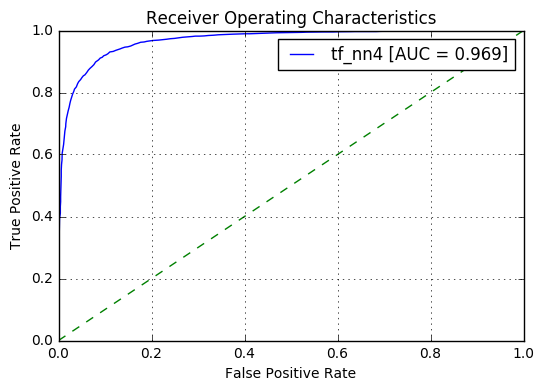

In [24]:
n_images = len(paths)
n_batches = int(math.ceil(n_images / batch_size))
embeddings_array = np.zeros((n_images, embeddings_size))


for i in range(n_batches):
    print("Batch %s/%s;" % (i, n_batches), end='')
    s_time = time.time()
    start_index = i*batch_size
    end_index = min((i+1)*batch_size, n_images)
    
    paths_batch = paths[start_index:end_index]
    
    images = load_data(paths_batch, image_size)
    feed_dict = { images_placeholder:images, phase_train_placeholder:False  }
    embeddings_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)
    print("duration: ", time.time() - s_time)

tpr, fpr, accuracy, val, val_std, far = evaluate(embeddings_array, random_seed, actual_issame, nrof_folds=n_folds)
auc = calc_auc(fpr, tpr)


print('Accuracy: %1.3f+-%1.3f' % (np.mean(accuracy), np.std(accuracy)))
print('Validation rate: %2.5f+-%2.5f @ FAR=%2.5f' % (val, val_std, far))
print('AUC: %1.3f' % auc)
facenet.plot_roc(fpr, tpr, 'tf_nn4 [AUC = %1.3f]' % auc)


# Camera Demo

## Record samples

sample photos for person

In [12]:
import cv2

def init_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)

person_name = 'Marko'
output_root = 'data/samples/'

out_dir = os.path.join(output_root, person_name)
init_dir(out_dir)
print(out_dir)
n = 500
skip = 10

cap = cv2.VideoCapture(0)
i = 0

while True:
    ret, frame = cap.read()
    i += 1
        
    cv2.imshow('frame', frame)
    key = cv2.waitKey(1) & 0xff
    if key == ord('q'):
        break
    if i % skip != 0: continue

    s = cv2.imwrite(os.path.join(out_dir, '%07d.png' % (i/skip)), frame)
    print(i/skip, s)

data/samples/Marko
1.0 True
2.0 True
3.0 True
4.0 True
5.0 True
6.0 True
7.0 True
8.0 True
9.0 True
10.0 True
11.0 True
12.0 True
13.0 True
14.0 True
15.0 True
16.0 True
17.0 True
18.0 True
19.0 True
20.0 True
21.0 True
22.0 True
23.0 True
24.0 True
25.0 True
26.0 True
27.0 True
28.0 True
29.0 True
30.0 True
31.0 True
32.0 True
33.0 True
34.0 True
35.0 True
36.0 True
37.0 True
38.0 True
39.0 True
40.0 True


In [32]:
cv2.destroyAllWindows()
cap.release()

In [6]:
import cv2
from os.path import join, basename

class Person:
    def __init__(self, name, root_dir):
        self.name = name
        self.root_dir = root_dir
        
    def load_paths(self, formats=['.png']):
        self.paths = []
        for ext in formats:
            self.paths += glob(join(self.root_dir, '*' + ext))
        
        
    def load_imgs(self, img_size=96, formats=['.png'], align=False):
        self.load_paths(formats)
        
        self.imgs = []
        for path in self.paths:
            if align:
                faces = get_faces_from_img(cv2.imread(path))
                self.imgs.extend([prewhiten(f) for f in faces])
            else:
                self.imgs.append(load_data([path], img_size)[0])
            
        self.imgs = np.array(self.imgs)


def load_imgs(paths):
    return load_data(paths, image_size=96)

In [11]:
# load dataset
from glob import glob

def get_embeddings(imgs):
    feed_dict = { images_placeholder:imgs, phase_train_placeholder:False  }
    return sess.run(embeddings, feed_dict=feed_dict)

root = './data/aligned_lfw/'
prealigned = False
names = os.listdir(root)
n_per_person = 10

people = [Person(d, join(root, d)) for d in names]
selected = []
for p in people: 
    p.load_paths()
    if len(p.paths) > n_per_person:
        p.load_imgs(align=prealigned)
        selected.append(p)
    
    
    
def create_samples(people):
    Xs = []; ys = []; to_names = dict()
    
    for i, p in enumerate(people):
        Xs += get_embeddings(p.imgs[:n_per_person]).tolist()
        ys += [i] * len(p.imgs[:n_per_person])
        to_names[i] = p.name
        
    return np.vstack(Xs), np.vstack(ys), to_names

Xs, ys, to_names = create_samples(selected)
print(len(Xs), len(ys), len(selected))

1550 1550 155


In [12]:
len(selected)
print('\n'.join(map(str, to_names.items())))

(0, 'James_Blake')
(1, 'Bill_Simon')
(2, 'Hu_Jintao')
(3, 'Mohammed_Al-Douri')
(4, 'Gerhard_Schroeder')
(5, 'Kim_Ryong-sung')
(6, 'John_Negroponte')
(7, 'Juan_Carlos_Ferrero')
(8, 'Richard_Myers')
(9, 'Hillary_Clinton')
(10, 'Angelina_Jolie')
(11, 'Tim_Henman')
(12, 'Mark_Philippoussis')
(13, 'Arnold_Schwarzenegger')
(14, 'Spencer_Abraham')
(15, 'Mike_Weir')
(16, 'Wen_Jiabao')
(17, 'Kim_Clijsters')
(18, 'Walter_Mondale')
(19, 'Rubens_Barrichello')
(20, 'John_Ashcroft')
(21, 'Gray_Davis')
(22, 'Sergey_Lavrov')
(23, 'Anna_Kournikova')
(24, 'Andre_Agassi')
(25, 'John_Howard')
(26, 'Michael_Jackson')
(27, 'Colin_Powell')
(28, 'Norah_Jones')
(29, 'Vladimir_Putin')
(30, 'Nicole_Kidman')
(31, 'Ricardo_Lagos')
(32, 'Jeremy_Greenstock')
(33, 'Naji_Sabri')
(34, 'George_Robertson')
(35, 'Kofi_Annan')
(36, 'John_Kerry')
(37, 'Yasser_Arafat')
(38, 'Lleyton_Hewitt')
(39, 'Jeb_Bush')
(40, 'Winona_Ryder')
(41, 'Megawati_Sukarnoputri')
(42, 'Charles_Moose')
(43, 'Mahathir_Mohamad')
(44, 'Dominique_de_V

In [16]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.33, random_state=42)

In [17]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = [
    {'C': [1, 10, 100, 1000],
     'kernel': ['linear']},
    {'C': [1, 10, 100, 1000],
     'gamma': [0.001, 0.0001],
     'kernel': ['rbf']}
]

clf = SVC(C=1, kernel='linear', probability=True)
clf.fit(X_train, y_train)

print(accuracy_score(y_train, clf.predict(X_train)))
print(accuracy_score(y_test, clf.predict(X_test)))
print(accuracy_score(ys, clf.predict(Xs)))

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


0.789980732177
0.513671875
0.698709677419


In [15]:
from sklearn.externals import joblib

path = './saved_models/lfw_10.svm'
joblib.dump(clf, path)

['./saved_models/lfw_10.svm',
 './saved_models/lfw_10.svm_01.npy',
 './saved_models/lfw_10.svm_02.npy',
 './saved_models/lfw_10.svm_03.npy',
 './saved_models/lfw_10.svm_04.npy',
 './saved_models/lfw_10.svm_05.npy',
 './saved_models/lfw_10.svm_06.npy',
 './saved_models/lfw_10.svm_07.npy',
 './saved_models/lfw_10.svm_08.npy',
 './saved_models/lfw_10.svm_09.npy',
 './saved_models/lfw_10.svm_10.npy',
 './saved_models/lfw_10.svm_11.npy']

In [50]:
from sklearn.externals import joblib

path = './saved_models/marko_ante.svm'
clf = joblib.load(path)

In [18]:
def analyze(frame):
    s = time.time()
    faces = get_faces_from_img(frame)
    if not faces:
        return [], []

    es = get_embeddings([prewhiten(f) for f in faces])
    probas = clf.predict_proba(es)
    print("Faces: %d, duration: %f" % (len(faces), time.time() - s))
    
    return faces, probas

def get_report(probas, top_n=5):
    ans = []
    for i in np.argsort(-np.array(probas))[:top_n]:
        ans.append('%s: %f' % (to_names[i], probas[i]))
    return '\n'.join(ans)
        

def capture_frame(): 
    print("Press q to take photo")
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        cv2.imshow('frame', frame)
    cap.release()
    return frame

def to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


from urllib.request import urlopen
def url_to_image(url):
    resp = urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    return cv2.imdecode(image, cv2.IMREAD_COLOR)
    
    

Faces: 2, duration: 1.180321


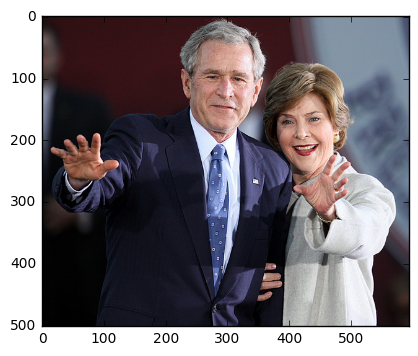

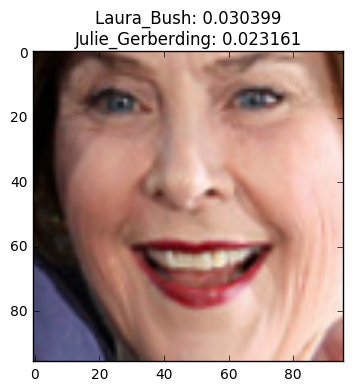

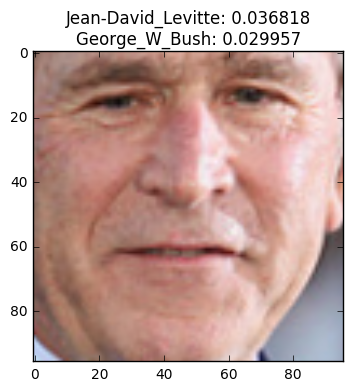

In [19]:
# sample from url
frame = url_to_image('http://www2.pictures.gi.zimbio.com/Texas+Rally+Welcomes+George+Bush+Back+Lone+PS4SXjRi4ngl.jpg')
faces, probas = analyze(frame)
plt.imshow(to_rgb(frame))
for f, p in zip(faces, probas):
    plt.figure()
    plt.imshow(to_rgb(f))
    plt.title(get_report(p, top_n=2))

Press q to take photo
Faces: 2, duration: 0.429234


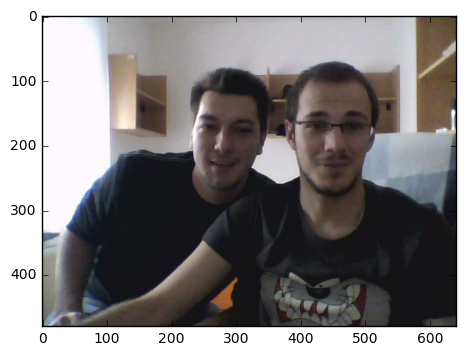

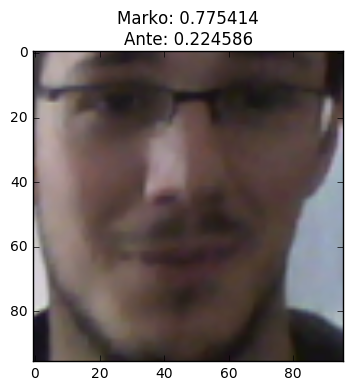

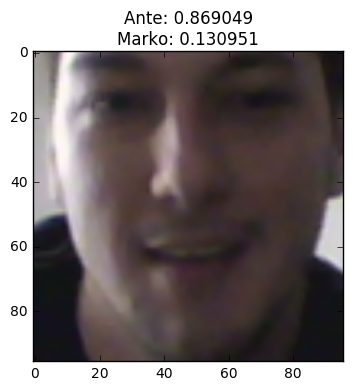

In [55]:
# from cam
frame = capture_frame()
faces, probas = analyze(frame)
plt.imshow(to_rgb(frame))
for f, p in zip(faces, probas):
    plt.figure()
    plt.imshow(to_rgb(f))
    plt.title(get_report(p, top_n=2))